**IMPORT LIBRARIES**

In [ ]:
import tensorflow as tf
import os
import numpy as np
import math
import glob
import cv2
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, Model
from keras.layers import TimeDistributed, Lambda
from keras.layers import Conv2D, Dense,Input, Dropout, Flatten, ZeroPadding2D, BatchNormalization
from keras.layers import RepeatVector, MaxPool2D, LSTM, Bidirectional
from keras.layers import CuDNNLSTM
from keras.optimizers import Adam
from keras import backend as K, layers
from collections import Counter
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, Sequence
from keras.callbacks import ModelCheckpoint

**EXTRACT TEXT AND FILE NAME FROM WORD TEXT FILE**

In [ ]:
# d is the dictionary of key:file name, value:word text  
d = {}

# status of the word means that properly segmented or not. Two status - err:means word not segmented properly, ok:means word properly segmented.
# This contain only those word text which status is ok.
status = []

#key of dictionary which is file name
keys = []
with open('/content/drive/MyDrive/words.txt') as f:
    for line in f:
        #split the line
        line = line.split(' ')
        status.append(line[1])
        if line[1] == 'ok':
            key = line[0]
            keys.append(line[0])
            text = line[8]
            text = text[:-1]
            d[key] = text
    f.close()
# Ground truth text. Actual word
gtText = []
for _, val in d.items():
    gtText.append(val)

In [ ]:
len(gtText)

96431

In [ ]:
vocab = set("".join(map(str, gtText)))
print(sorted(vocab))

['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
len(vocab)

78

**ENCODE TEXT TO DIGIT**

In [ ]:
char_list = sorted(vocab)

def encode_to_labels(txt):

    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [ ]:
# Check - encode the text.
encode_to_labels("HELLO")

[33, 30, 37, 37, 40]

In [ ]:
# max length of ground truth text
max_label_len = max([len(str(text)) for text in gtText])

In [ ]:
max_label_len

21

In [ ]:
!unzip "/content/drive/MyDrive/iam_dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: words/p06/p06-069/p06-069-03-06.png  
  inflating: words/p06/p06-069/p06-069-03-07.png  
  inflating: words/p06/p06-069/p06-069-03-08.png  
  inflating: words/p06/p06-069/p06-069-03-09.png  
  inflating: words/p06/p06-069/p06-069-03-10.png  
  inflating: words/p06/p06-069/p06-069-04-00.png  
  inflating: words/p06/p06-069/p06-069-04-01.png  
  inflating: words/p06/p06-069/p06-069-04-02.png  
  inflating: words/p06/p06-069/p06-069-04-03.png  
  inflating: words/p06/p06-069/p06-069-04-04.png  
  inflating: words/p06/p06-069/p06-069-04-05.png  
  inflating: words/p06/p06-069/p06-069-04-06.png  
  inflating: words/p06/p06-069/p06-069-05-00.png  
  inflating: words/p06/p06-069/p06-069-05-01.png  
  inflating: words/p06/p06-069/p06-069-05-02.png  
  inflating: words/p06/p06-069/p06-069-05-03.png  
  inflating: words/p06/p06-069/p06-069-05-04.png  
  inflating: words/p06/p06-069/p06-069-05-05.png  
  inflating: words/p06/p06-069/

In [ ]:
ls

drive/  linux_gt.txt  sample_data/  train_gt.txt  val_gt.txt  words/


**PATH OF IMAGE OF TEXT**

In [ ]:
file_path = '/content/words/**/**/****.png'
path = glob.glob(file_path)
path.sort()

In [ ]:
image_path = []
for img_path in path:
    paths = img_path.split('/')[-1].split('.')[0]
    if paths in keys:
        image_path.append(img_path)

In [ ]:
len(image_path)

96431

In [ ]:
train_final_paths = image_path[ : int(len(image_path) * 0.90)]
train_final_texts = gtText[ : int(len(gtText) * 0.90)]

val_final_paths = image_path[int(len(image_path) * 0.90) : ]
val_final_texts = gtText[int(len(gtText) * 0.90) : ]

In [ ]:
train_final_paths[1]

'/content/words/a01/a01-000u/a01-000u-00-01.png'

**IMAGE PREPROCESSING**

In [ ]:
def process(img_path):
    image_path = []
    for path in img_path:

        img = cv2.imread(path, 0)

        (wt, ht) = (128, 32)
        (h, w) = img.shape
        fx = w / wt
        fy = h / ht
        f = max(fx, fy)
                
        newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))
                
        img = cv2.resize(img, newSize)
        img = img/255
                    
        target = np.ones([ht, wt]) * 255
                
        if newSize[1] < 32:
            img = np.concatenate((img, target[newSize[1]:32]), axis=0)    
                
        if newSize[0] < 128:
            img = np.concatenate((img, target[:,newSize[0]:128]), axis=1)

        img = cv2.transpose(img)

        img = img.reshape(128, 32, 1)

        image_path.append(img)
    return image_path

In [ ]:
# preprocess all the training and vslidation image data
train_final_path = process(train_final_paths)
val_final_path = process(val_final_paths)

In [ ]:
class My_Generator(Sequence):
    
    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        
#       create batch
        batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        training_txt = []
        label_length = []
        input_length = []

        for img, text in zip(batch_paths, batch_texts):

            images.append(img)
            training_txt.append(encode_to_labels(text))
            label_length.append(len(text))
            input_length.append(32)
        
        return [np.array(images), 
                  pad_sequences(training_txt, maxlen=max_label_len, padding='post', value=len(char_list)), 
                  np.array(input_length), 
                  np.array(label_length)], np.zeros(len(images))

In [ ]:
batch_size =128
train_generator = My_Generator(train_final_path, train_final_texts, batch_size)
val_generator = My_Generator(val_final_path, val_final_texts, batch_size)

**MODEL**

In [ ]:

input_shape = Input(shape=(128, 32, 1))
# First layer
conv1 = Conv2D(32, (5, 5), activation='relu', padding = 'SAME', strides = (1, 1))(input_shape)
batch1 = BatchNormalization()(conv1)
pool1 = MaxPool2D(pool_size=(2,2),strides = (2, 2), padding = 'valid')(batch1)

# Second layer
conv2 = Conv2D(64, (5, 5), activation='relu', padding = 'SAME', strides = (1, 1))(pool1)
batch2 = BatchNormalization()(conv2)
pool2 = MaxPool2D(pool_size=(2,2),strides = (2, 2), padding = 'valid')(batch2)

# Third layer
conv3 = Conv2D(128, (3, 3), activation='relu', padding = 'SAME', strides = (1, 1))(pool2)
batch3 = BatchNormalization()(conv3)
pool3 = MaxPool2D(pool_size=(1,2),strides = (1, 2), padding = 'valid')(batch3)

# Fourth layer          
conv4 = Conv2D(128, (3, 3), activation='relu', padding = 'SAME', strides = (1, 1))(pool3)
batch4 = BatchNormalization()(conv4)
pool4 = MaxPool2D(pool_size=(1,2),strides = (1, 2), padding = 'valid')(batch4)

# Fifth layer             
conv5 = Conv2D(256, (3, 3), activation='relu', padding = 'SAME', strides = (1, 1))(pool4)
batch5 = BatchNormalization()(conv5)
pool5 = MaxPool2D(pool_size=(1,2),strides = (1, 2), padding = 'valid')(batch5)

# Reduce the dimension of output of fifth layer
cnn_input = tf.squeeze(pool5, [2])

# The output of convolutional layer is the input of bidirectional LSTM layer
forward_lstm = CuDNNLSTM(256, return_sequences=True)
backward_lstm = CuDNNLSTM(256, return_sequences=True, go_backwards=True)

bidirectional = Bidirectional(forward_lstm, backward_layer=backward_lstm)(cnn_input)

# output of model
output_layer = Dense(len(char_list)+1, activation='softmax')(bidirectional)

my_model = Model(inputs = input_shape, outputs = output_layer)

In [ ]:
my_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 32, 1)]      0         
                                                                 
 conv2d_27 (Conv2D)          (None, 128, 32, 32)       832       
                                                                 
 batch_normalization_11 (Bat  (None, 128, 32, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 64, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 16, 64)        51264     
                                                                 
 batch_normalization_12 (Bat  (None, 64, 16, 64)       256 

**CTC LOSS FUNCTION**

In [ ]:
# Encoded word text is the labels
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
# Input length which is 32
input_length = Input(name='input_length', shape=[1], dtype='int64')
# label_length is the length of word text
label_length = Input(name='label_length', shape=[1], dtype='int64')

# ctc_batch_cost use from keras backend
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, 
                  output_shape=(1,), 
                  name='ctc')([output_layer, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[input_shape, labels, input_length, label_length], outputs=loss_out)

**COMPILE THE MODEL**

In [ ]:
# weight file 
file_path = "C_LSTM_best.hdf5"
from keras.optimizers import RMSprop

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = RMSprop(0.001), metrics=['accuracy'])


checkpoint = ModelCheckpoint(filepath=file_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

callbacks_list = [checkpoint]

**MODEL TRAINING**

In [ ]:
epochs =15
history = model.fit(train_generator, 
                    epochs = epochs,
                    steps_per_epoch = len(train_final_paths)/batch_size,
                    validation_data=val_generator,
                    validation_steps = len(val_final_paths)/batch_size,
                    verbose = 1,
                    callbacks = callbacks_list,
                    shuffle=True)


Epoch 1/15
679/678 [==============================] - ETA: 0s - loss: 12.7009 - accuracy: 0.0306
Epoch 1: val_loss improved from inf to 15.26327, saving model to C_LSTM_best.hdf5
678/678 [==============================] - 74s 105ms/step - loss: 12.7009 - accuracy: 0.0306 - val_loss: 15.2633 - val_accuracy: 0.0934
Epoch 2/15
679/678 [==============================] - ETA: 0s - loss: 6.7529 - accuracy: 0.1992
Epoch 2: val_loss improved from 15.26327 to 8.86049, saving model to C_LSTM_best.hdf5
678/678 [==============================] - 72s 107ms/step - loss: 6.7529 - accuracy: 0.1992 - val_loss: 8.8605 - val_accuracy: 0.2287
Epoch 3/15
679/678 [==============================] - ETA: 0s - loss: 4.1065 - accuracy: 0.3286
Epoch 3: val_loss improved from 8.86049 to 4.38533, saving model to C_LSTM_best.hdf5
678/678 [==============================] - 71s 105ms/step - loss: 4.1065 - accuracy: 0.3286 - val_loss: 4.3853 - val_accuracy: 0.3446
Epoch 4/15
679/678 [==============================] - 

**LOSS AND ACCURACY CURVE**

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

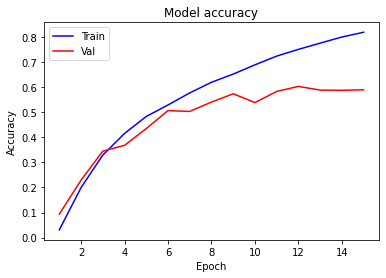

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'r')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

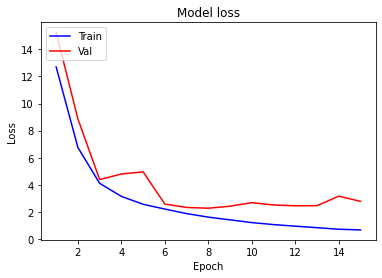

In [ ]:
plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

**PREPROCESS IMAGE BEFORE PREDICTION**

In [ ]:
def pre_process_image(path):
    
    #img =cv2.imread(path, cv2.COLOR_BGR2GRAY)
    img = path
        
    (wt, ht) = (128, 32)
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
                
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))
                
    img = cv2.resize(img, newSize)
    img = img/255
                    
    target = np.ones([ht, wt]) * 255
                
    if newSize[1] < 32:
        img = np.concatenate((img, target[newSize[1]:32]), axis=0)    
                
    if newSize[0] < 128:
        img = np.concatenate((img, target[:,newSize[0]:128]), axis=1)
        
    img = cv2.transpose(img)

    img = img.reshape(128, 32, 1)

    
    return img

**LOAD WEIGHT FILE IN MODEL**

In [ ]:
my_model.load_weights('C_LSTM_best.hdf5')

In [ ]:
def predict_output(img):
    # predict outputs
    prediction = my_model.predict(np.array([img]))

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction, 
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True, beam_width=100, top_paths=1)[0][0])

    ## get the final text
    for x in out:
        print("predicted text = ", end = '')
        for p in x:
            
            if int(p) != -1:
                print(char_list[int(p)], end = '')
        
        print(' ', end='')

**PREDICTING TEST IMAGES**

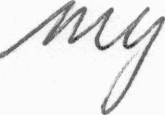



original text= my
1/1 [==============================] - 0s 16ms/step
predicted text = my 

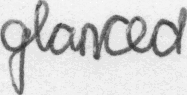



original text= glanced
1/1 [==============================] - 0s 15ms/step
predicted text = glanced 

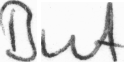



original text= But
1/1 [==============================] - 0s 15ms/step
predicted text = But 

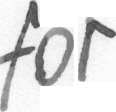



original text= for
1/1 [==============================] - 0s 17ms/step
predicted text = for 

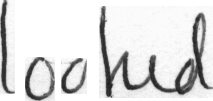



original text= looked
1/1 [==============================] - 0s 15ms/step
predicted text = lootud 

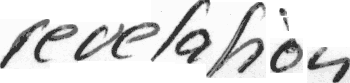



original text= revelation
1/1 [==============================] - 0s 15ms/step
predicted text = revelation 

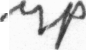



original text= up
1/1 [==============================] - 0s 18ms/step
predicted text = up 

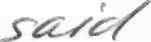



original text= said
1/1 [==============================] - 0s 23ms/step
predicted text = said 



original text= .
1/1 [==============================] - 0s 15ms/step
predicted text = . 

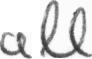



original text= all
1/1 [==============================] - 0s 17ms/step
predicted text = all 

In [ ]:
from IPython.display import display
from random import randrange
from PIL import Image

for i in range(10):
    index = randrange(len(val_final_paths))
    txt=val_final_texts[index]
    im = Image.open(val_final_paths[index])
    display(im)
    
    print("\n")
    print('original text=',txt)
    test_img =pre_process_image(val_final_paths[index])
    predict_output(test_img)

**PREDICTING RANDOM IMAGE**

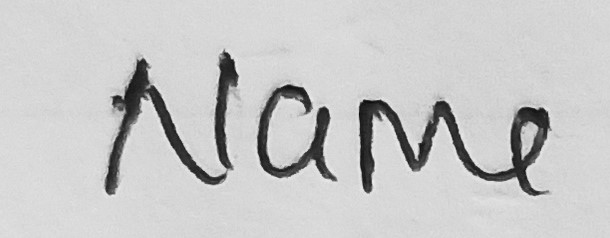

In [ ]:
image=cv2.imread('/content/name.jpg', cv2.IMREAD_GRAYSCALE)
from google.colab.patches import cv2_imshow
cv2_imshow(image)
img=pre_process_image(image)

In [ ]:

predict_output(img)

1/1 [==============================] - 0s 25ms/step
predicted text = Name 